The Data Science Stack Exchange website is a forum for data science professionals and enthusiasts to ask questions and give advice. The questions are voted up or down by community members which shows their relevance to the community and the amount of activity in the thread. Questions are also tagged with different topics, such as machine learning or python, so they can be easily categorized and searched. Community members can either look for preexisting topics, search for threads that relate to their questions or or post a question if they can't find an existing thread. 

There are a lot of tables available for exploration. A few of the most interesting ones are the Posts table, the Comments table, and the Tags table. The User table could also be interesting to learn about which users have the highest reputation or post the most. 

We will look at the Posts table and use data from 2019.

In [1]:
# Read in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read csv file into a dataframe and inpect data types
posts = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])
posts.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount           float64
dtype: object

In [2]:
# Inspect shape of the data and look for null values
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


Almost every column contains non-null values. The 'FavoriteCount' column has an overwhelming number of null-values, however. We can start by filling them with 0. Most columns seem to have the right data type. The Tags column could require some work to make it easier to use the individual tags.

In [3]:
# Fill in missing values with 0
posts.fillna(0, inplace=True)
# Clean up 'Tags' column
posts["Tags"] = posts["Tags"].str.replace("<","").str.replace(">", ",").str.strip(",")

To analyze the tags, we'll see which were most popular by looking at how many times each was used and how many times each was viewed.

In [4]:
# Create dictionary to hold tag data
data = {"Tags":[], "Uses":[], "Views":[]}
# Create function to find frequency of tag use and views
def tag_use(row):
    
    string = row["Tags"]
    views = row["ViewCount"]
    tags = string.split(",")
    
    for tag in tags:
        if tag in data["Tags"]:  
            data["Uses"][data["Tags"].index(tag)] = data["Uses"][data["Tags"].index(tag)] + 1
            data["Views"][data["Tags"].index(tag)] = data["Views"][data["Tags"].index(tag)] + views
        else:        
            data["Tags"].append(tag)
            data["Uses"].append(1)
            data["Views"].append(views)

posts[["Tags", "ViewCount"]].apply(tag_use, axis=1)

# Create new dataframe with number of uses and views for each tag
tag_pop = pd.DataFrame(data)

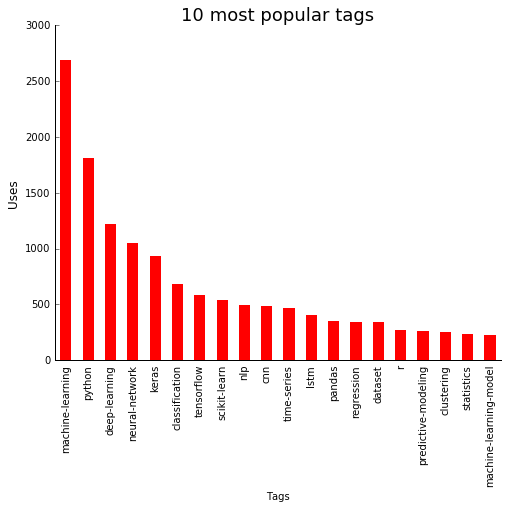

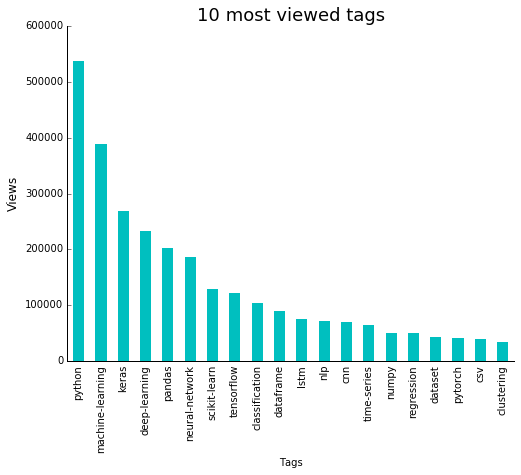

In [5]:
# Prepare top 20 in each column to graph
uses = tag_pop[["Tags", "Uses"]].sort_values(by="Uses", ascending=False)[0:20]
uses.reset_index(drop=True, inplace=True)
views = tag_pop[["Tags", "Views"]].sort_values(by="Views", ascending=False)[0:20]
views.reset_index(drop=True, inplace=True)

# Graph tags with top uses and views
ax1 = uses.plot(kind="bar", x="Tags", y="Uses", legend=False, figsize=(8,6), color="red", edgecolor="none")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.tick_params(top=False, right=False, bottom=False)
plt.ylabel("Uses", fontsize=12)
plt.title("10 most popular tags", fontsize=18)

ax2 = views.plot(kind="bar", x="Tags", y="Views", legend=False, figsize=(8,6), color="c", edgecolor="none")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.tick_params(top=False, right=False, bottom=False)
plt.ylabel("Views", fontsize=12)
plt.title("10 most viewed tags", fontsize=18)


Of these tags we will take a look at deep-learning and it's popularity over time on the Data Science Stack Exchange website. To do this we'll use another dataframe holding tags of all questions ever asked on the website.

In [6]:
# Read in new dataframe
all_questions = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])
all_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
Id              21576 non-null int64
CreationDate    21576 non-null datetime64[ns]
Tags            21576 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 505.8+ KB


In [7]:
# Inspect first few rows
all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [8]:
# Clean tags column
all_questions["Tags"] = all_questions["Tags"].str.replace("<", "").str.replace(">", ",").str.strip(",")
# Mark which rows are deep learning questions and store them in a column
all_questions["Deep_learning"] = all_questions["Tags"].apply(lambda string : 1 if "deep-learning" in string.split(",") else 0)
# Extract the months from the date and store in a column
all_questions["Month"] = all_questions["CreationDate"].apply(lambda date : date.strftime("%Y%m"))
# Group by month and count the questions
monthly_count = all_questions[all_questions["Deep_learning"] == 1].groupby("Month").sum()
monthly_count.drop("Id", inplace=True, axis=1)

([<matplotlib.axis.XTick at 0x7fade01a6a90>,
 <a list of 11 Text xticklabel objects>)

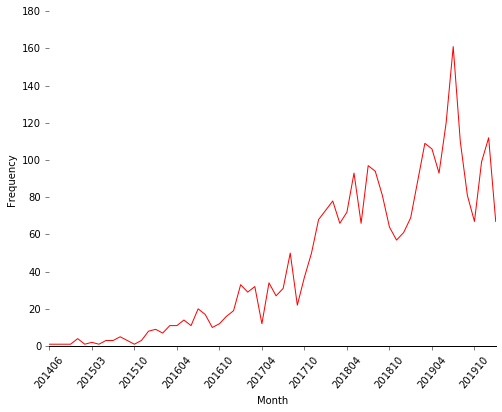

In [19]:
# Graph the frequency of deep learning questions over time
ax3 = monthly_count.plot(figsize=(8,6), legend=False, color="red")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["left"].set_visible(False)
plt.tick_params(top=False, right=False, direction="out")
plt.ylabel("Frequency")
# Set the x-ticks and the labels to show every 6th month for readability
x_ticks = [tick for tick in range(0,65,6)]
dates = monthly_count.index[::6]
plt.xticks(x_ticks, dates, rotation=50)

The above line graph shows the popularity of the deep-learning tag on DSSE. It's clear that for 2014 and most of 2015 there are very few questions being posted on about it. It's popularity starts to pick up in 2016 and increases rapidly to a sharp peak of over 160 uses in a month in mid-2019 before dropping again. It would appear that interest in deep-learning is not just a fad as the last few years has seen sustained activity using the tag.

In [18]:
# Let's look at the top 5 most used tags over time
for tag in list(uses["Tags"][0:5]):      
    all_questions[tag] = all_questions["Tags"].apply(lambda string: 1 if tag in string.split(",") else 0)
all_questions.drop(["Id","Deep_learning"], axis=1, inplace=True)

([<matplotlib.axis.XTick at 0x7fade01642e8>,
 <a list of 12 Text xticklabel objects>)

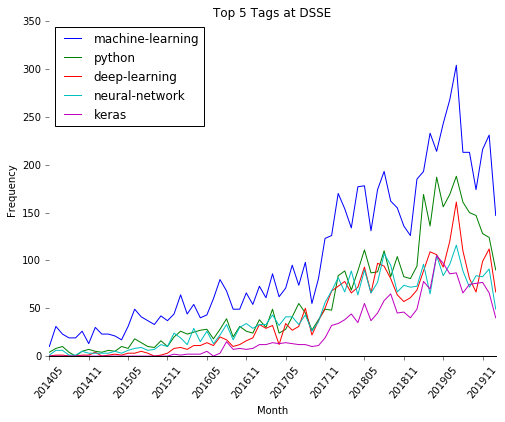

In [20]:
# Graph top 5 tags over time
ax4 = all_questions.groupby("Month").sum().plot(figsize=(8,6))
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["left"].set_visible(False)
plt.tick_params(top=False, right=False, labelbottom=True, direction="out")
plt.ylabel("Frequency")
plt.title("Top 5 Tags at DSSE")
# Set the x-ticks and the labels to show every 6th month for readability
x_ticks = [tick for tick in range(0,69,6)]
dates = all_questions.groupby("Month").sum().index[::6]
plt.xticks(x_ticks, dates, rotation=50, text=None)

Machine learning, deep learning, and neural networks are all associated with each other so it would be interesting to see how often deep learning or neural network is used in conjunction with a machine learning tag.

In [42]:
# Calculate when machine-learning, deep-learning, and neural-network appear together
def assoc(row):
    """Function to take in row of booleans representing different tags and 
    return 0,1,2,3, or 4 depending on the combinations of tags present in the
    row"""
    
    ml = row["machine-learning"]
    dl = row["deep-learning"]
    nn = row["neural-network"]
    
    if ml == 0:
        return 0
    else:
        if dl == 0 and nn == 0:
            return "ml only"
        elif dl == 1 and nn == 0:
            return "ml and dl"
        elif dl == 0 and nn == 1:
            return "ml and nn"
        else:
            return "ml and dl and nn"
    
all_questions["ML,DL,NN"] = all_questions[["machine-learning","deep-learning","neural-network"]].apply(assoc, axis=1)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

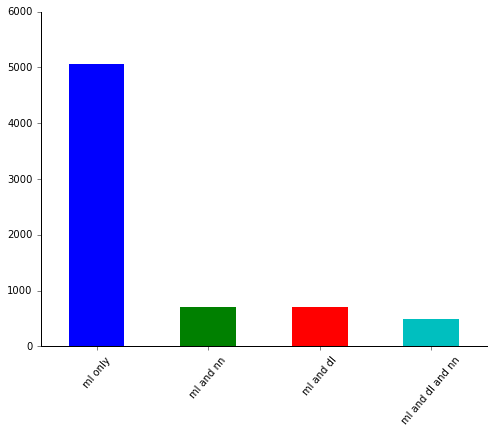

In [54]:
# Plot how often the tags appear together
ax5 = all_questions["ML,DL,NN"].value_counts()[1:5].plot(kind='bar', figsize=(8,6), edgecolor='none')
ax5.tick_params(top=False, right=False, direction='out')
ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
plt.xticks(rotation=50)